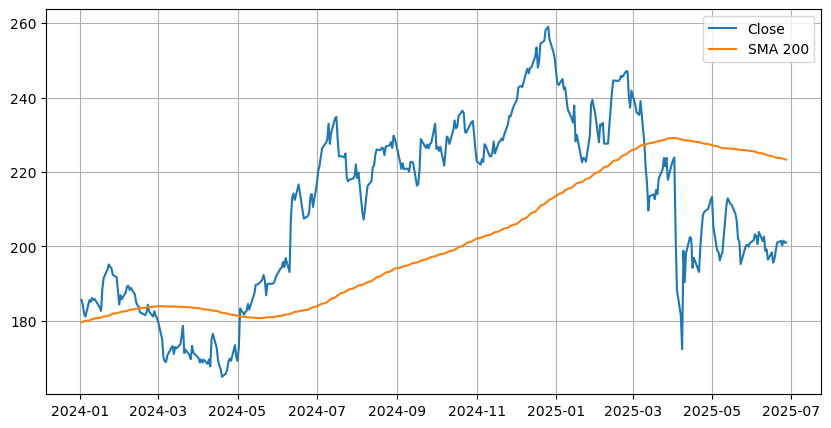

In [10]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt

# 이동평균선
df = fdr.DataReader("AAPL")
df["SMA_200"] = df["Close"].rolling(window = 200).mean()   # 200일치씩 묶은 이동평균선

df2 = df[df.index.year >= 2024]

plt.figure(figsize = (10, 5))
plt.plot(df2["Close"])
plt.plot(df2["SMA_200"])
plt.legend(["Close", "SMA 200"])
plt.grid()
plt.show()

# 서서히올라가다가 최근 좀 내려가는 추세 확인 가능

# 단기 5일 이동평균선 / 장기 20일 이동평균선

골든크로스 : 단기 이평선이 장기 이평선을 아래에서 위로 뚫고 올라가는 시점 = 매수신호 (종목의 상승 추세 예상)        
데드크로스 : 단기 이평선이 장기 이평선을 뚫고 위에서 아래로 하향하는 시점 = 매도신호

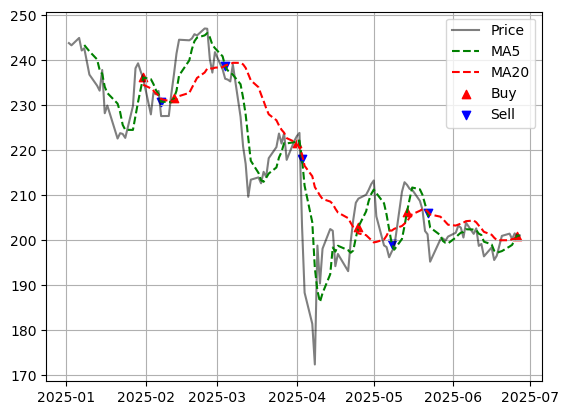

In [20]:
df = fdr.DataReader("AAPL")
df = df[df.index.year >= 2025]

# 단기 5일 이동평균선 / 장기 20일 이동평균선
df['MA5'] = df['Close'].rolling(window = 5).mean()
df['MA20'] = df['Close'].rolling(window = 20).mean()

# 골든크로스 / 데드크로스
# 단기 이평선 > 장기 이평선 이면 1, 아니면 0
df['Signal'] = 0
df.loc[df['MA5'] > df['MA20'], 'Signal'] = 1

# 교차 지점 찾기
# 전일 대비 Signal이 1 증가하면 골든크로스, 감소하면 데드크로스
df["Position"] = df['Signal'].diff()

plt.plot(df.index, df['Close'], color = 'black', alpha = 0.5)
plt.plot(df.index, df['MA5'], color = 'green', linestyle = '--')
plt.plot(df.index, df['MA20'], color = 'red', linestyle = '--')

plt.scatter(df[df['Position'] == 1].index,
         df['MA5'][df['Position'] == 1], marker = '^', color = 'red')     # 골든크로스 시점 (Signal이 0 → 1로 바뀌는 시점)

plt.scatter(df[df['Position'] == -1].index,
         df['MA5'][df['Position'] == -1], marker = 'v', color = 'blue')   # 데드크로스 시점 (Signal이 1 → 0으로 바뀌는 시점)

plt.legend(['Price', 'MA5', 'MA20', "Buy", 'Sell'])
plt.grid()
plt.show()

In [25]:
# !pip install backtesting
import warnings 
warnings.filterwarnings("ignore")

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

class MAStrategy(Strategy):
    n1 = 5  # 5일 이평선
    n2 = 20  # 20일 이평선

    def init(self):
        self.ma1 = self.I(pd.Series(self.data.Close).rolling(self.n1).mean)
        self.ma2 = self.I(pd.Series(self.data.Close).rolling(self.n2).mean)
        
    def next(self):
        if crossover(self.ma1, self.ma2):
            if not self.position:
                self.buy()
        elif crossover(self.ma2, self.ma1):
            if self.position:
                self.position.close()

In [27]:
df = fdr.DataReader("AAPL")

# 자본금 10000달러, 수수료 0.2%
bt = Backtest(df, MAStrategy, cash = 10000, commission = 0.002)

stats = bt.run()
stats

Backtest.run:   0%|          | 0/11206 [00:00<?, ?bar/s]

Start                     1980-12-12 00:00:00
End                       2025-06-27 00:00:00
Duration                  16268 days 00:00:00
Exposure Time [%]                    59.41564
Equity Final [$]                   988257.902
Equity Peak [$]                 1434393.14578
Commissions [$]                  219736.42048
Return [%]                         9782.57902
Buy & Hold Return [%]            142325.07699
Return (Ann.) [%]                    10.86147
Volatility (Ann.) [%]                33.61041
CAGR [%]                              7.37461
Sharpe Ratio                          0.32316
Sortino Ratio                          0.5506
Calmar Ratio                          0.16011
Alpha [%]                        -52040.27199
Beta                                  0.43438
Max. Drawdown [%]                   -67.83695
Avg. Drawdown [%]                    -7.09958
Max. Drawdown Duration     2739 days 00:00:00
Avg. Drawdown Duration       96 days 00:00:00
# Trades                          

In [29]:
bt.plot()
plt.show()

# 최신경향을 반영

In [34]:
# 가중 이동 평균 // 최신 데이터에 더 높은 가중치를 주기 위해서

import numpy as np
df = fdr.DataReader("AAPL")

window = 10

weights = np.arange(1, window + 1)

df["Close"].rolling(window).apply(lambda x : np.dot(x, weights) / weights.sum())    # 내적값 / 다 더한값

1980-12-12           NaN
1980-12-15           NaN
1980-12-16           NaN
1980-12-17           NaN
1980-12-18           NaN
                 ...    
2025-06-23    198.887636
2025-06-24    199.093273
2025-06-25    199.548909
2025-06-26    199.922909
2025-06-27    200.271091
Name: Close, Length: 11226, dtype: float64

In [39]:
# 지수 이동 평균선(EMA: Exponential MA)
data = {"Close" : [100, 102, 108, 104, 111]}
data = pd.DataFrame(data)
data["EMA"] = data["Close"].ewm(span = 3, adjust=False).mean()
data["EMA2"] = data["Close"].ewm(alpha = 0.5, adjust=False).mean()
data
# (전날 EMA값 * 알파) + (오늘 종가 * 알파)       ..... 알파 : 2 / (Span + 1)

,Close,EMA,EMA2
0,100,100.000,100.000
1,102,101.000,101.000
2,108,104.500,104.500
3,104,104.250,104.250
4,111,107.625,107.625
